**Importing Modules**

In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import nltk
import sklearn

In [ ]:
seed = 1306

np.random.seed(seed)
torch.manual_seed(seed)

**Loading the Dataset**

In [8]:
ds = datasets.load_dataset('arbml/Arabic_Sentiment_Twitter_Corpus')

Repo card metadata block was not found. Setting CardData to empty.


In [9]:
ds

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 47000
    })
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 11751
    })
})

In [10]:
train_val_test = ds['test'].train_test_split(test_size=0.5, seed=42)

ds = {
    "train": ds["train"],
    "validation": train_val_test["train"],
    "test": train_val_test["test"],
}

In [11]:
ds

{'train': Dataset({
     features: ['tweet', 'label'],
     num_rows: 47000
 }),
 'validation': Dataset({
     features: ['tweet', 'label'],
     num_rows: 5875
 }),
 'test': Dataset({
     features: ['tweet', 'label'],
     num_rows: 5876
 })}

In [12]:
ds['train'][0]

{'tweet': 'اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭',
 'label': 0}

In [13]:
ds['train'].features

{'tweet': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

In [2]:
from datasets import Features, Value, ClassLabel, Sequence

target_features = Features({
    "tweet": Value("string"),
    "label": ClassLabel(names=["neg", "pos"]),
    "tokens": Sequence(Value("string"))
})

**Tokenization**

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
text = 'اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭'
print(nltk.word_tokenize(text))

['اعترف', 'ان', 'بتس', 'كانو', 'شوي', 'شوي', 'يجيبو', 'راسي', 'لكن', 'اليوم', 'بالزايد', '😭']


In [16]:
def tokenize(example, tokenizer, max_length):
    tokens = tokenizer(example["tweet"])[:max_length]
    return {"tokens": tokens}

In [19]:
max_length = 256

train_data = ds['train'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)
valid_data = ds['validation'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)
test_data = ds['test'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)

Map:   0%|          | 0/47000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5875 [00:00<?, ? examples/s]

Map:   0%|          | 0/5876 [00:00<?, ? examples/s]

In [20]:
train_data[3536]

{'tweet': 'احل شوف اذا تبي فكرتي عشان الفقرات اشتر D printer وورق صنفرة والي يبقى عليك التلوين بس 🌚',
 'label': 0,
 'tokens': ['احل',
  'شوف',
  'اذا',
  'تبي',
  'فكرتي',
  'عشان',
  'الفقرات',
  'اشتر',
  'D',
  'printer',
  'وورق',
  'صنفرة',
  'والي',
  'يبقى',
  'عليك',
  'التلوين',
  'بس',
  '🌚']}

In [21]:
train_data

Dataset({
    features: ['tweet', 'label', 'tokens'],
    num_rows: 47000
})

In [22]:
train_data.features

{'tweet': Value('string'),
 'label': ClassLabel(names=['neg', 'pos']),
 'tokens': List(Value('string'))}

In [23]:
valid_data[0]["tokens"][:25]

['رغبتك', 'تنزل', 'ع', 'سمعي', 'مطر', '💙']

In [24]:
len(train_data), len(valid_data), len(test_data)

(47000, 5875, 5876)

**Creating a Vocabulary**

In [25]:
from collections import Counter

counter = Counter(token for tokens in train_data["tokens"] for token in tokens)
special_tokens = ["<unk>", "<pad>"]
stoi = {tok: i for i, tok in enumerate(special_tokens + [t for t, c in counter.items() if c >= 5])}
itos = {i: tok for tok, i in stoi.items()}

In [26]:
len(itos)

14926

In [27]:
unk_index = stoi["<unk>"]
pad_index = stoi["<pad>"]

In [28]:
# For the tokens that doesn't exist in stoi we should return unk_index
from collections import defaultdict
stoi = defaultdict(lambda: unk_index, stoi)

In [29]:
def lookup_indices(tokens):
    return [stoi[token] for token in tokens]

In [30]:
def lookup_tokens(ids):
    return [itos[Id] for Id in ids]

In [34]:
lookup_indices(['رغبتك', 'تنزل', 'ع', 'سمعي', 'مطر', '💙'])

[0, 6185, 239, 0, 4612, 3551]

**Numericalizing Data**

In [35]:
def numericalize_example(example):
    ids = lookup_indices(example["tokens"])
    return {"ids": ids}

In [36]:
train_data = train_data.map(numericalize_example)
valid_data = valid_data.map(numericalize_example)
test_data = test_data.map(numericalize_example)

Map:   0%|          | 0/47000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5875 [00:00<?, ? examples/s]

Map:   0%|          | 0/5876 [00:00<?, ? examples/s]

In [37]:
test_data[0]

{'tweet': '#الهلال ب مدافع و محاور سوال ل الكوتش #زوران الفريق اللي ناقص لاعب مين ؟؟ 🤔 #الاهلي_الهلال',
 'label': 0,
 'tokens': ['#',
  'الهلال',
  'ب',
  'مدافع',
  'و',
  'محاور',
  'سوال',
  'ل',
  'الكوتش',
  '#',
  'زوران',
  'الفريق',
  'اللي',
  'ناقص',
  'لاعب',
  'مين',
  '؟؟',
  '🤔',
  '#',
  'الاهلي_الهلال'],
 'ids': [22,
  28,
  407,
  0,
  53,
  9026,
  0,
  380,
  0,
  22,
  2015,
  5001,
  890,
  2296,
  1669,
  374,
  982,
  101,
  22,
  23]}

In [38]:
train_data[24]['tweet']

'بنشكر الله انو القلب عضلة مو عظم .. بضل التعضيل ارحم من الكسر 😔'

In [39]:
train_data[24]["tokens"][:20]

['بنشكر',
 'الله',
 'انو',
 'القلب',
 'عضلة',
 'مو',
 'عظم',
 '..',
 'بضل',
 'التعضيل',
 'ارحم',
 'من',
 'الكسر',
 '😔']

In [40]:
lookup_indices(train_data[24]["tokens"][:20])

[218, 135, 219, 220, 221, 222, 223, 81, 224, 225, 226, 68, 227, 137]

In [41]:
lookup_tokens(train_data[24]["ids"][:20])

['بنشكر',
 'الله',
 'انو',
 'القلب',
 'عضلة',
 'مو',
 'عظم',
 '..',
 'بضل',
 'التعضيل',
 'ارحم',
 'من',
 'الكسر',
 '😔']

In [42]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [43]:
train_data[24]["label"]

tensor(0)

In [44]:
train_data[24]["ids"][:10]

tensor([218, 135, 219, 220, 221, 222, 223,  81, 224, 225])

In [45]:
train_data[24]

{'label': tensor(0),
 'ids': tensor([218, 135, 219, 220, 221, 222, 223,  81, 224, 225, 226,  68, 227, 137])}

In [46]:
lookup_tokens(train_data[0]["ids"][:30].tolist())

['اعترف',
 'ان',
 'بتس',
 'كانو',
 'شوي',
 'شوي',
 'يجيبو',
 'راسي',
 'لكن',
 'اليوم',
 '<unk>',
 '😭']

**Creating Data Loaders**

In [47]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [48]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [49]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [50]:
next(iter(train_data_loader))

{'ids': tensor([[ 8063,   292,  3691,  ...,     1,     1,     1],
         [ 1293,  8800,    44,  ...,     1,     1,     1],
         [ 2388,   135,   449,  ...,     1,     1,     1],
         ...,
         [  185,     0,  4403,  ...,     1,     1,     1],
         [   99,  9347, 12725,  ...,     1,     1,     1],
         [    0,  3677, 11526,  ...,     1,     1,     1]]),
 'label': tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
         1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
         0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
         1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
         0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
         1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,

**Building the Model**

In [51]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [110]:
vocab_size = len(stoi)
embedding_dim = 128
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [111]:
model

NBoW(
  (embedding): Embedding(89919, 128, padding_idx=1)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [113]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 11,509,890 trainable parameters


In [114]:
optimizer = optim.Adam(model.parameters())

In [115]:
criterion = nn.CrossEntropyLoss()

In [116]:
def train(data_loader, model, criterion, optimizer):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"]
        label = batch["label"]
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [117]:
def evaluate(data_loader, model, criterion):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"]
            label = batch["label"]
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [118]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [119]:
n_epochs = 15
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow_v1.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.46it/s]


epoch: 0
train_loss: 0.657, train_acc: 0.655
valid_loss: 0.608, valid_acc: 0.774


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.53it/s]


epoch: 1
train_loss: 0.530, train_acc: 0.829
valid_loss: 0.466, valid_acc: 0.857


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.66it/s]


epoch: 2
train_loss: 0.397, train_acc: 0.884
valid_loss: 0.364, valid_acc: 0.890


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.73it/s]


epoch: 3
train_loss: 0.307, train_acc: 0.915
valid_loss: 0.297, valid_acc: 0.915


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.62it/s]


epoch: 4
train_loss: 0.244, train_acc: 0.935
valid_loss: 0.251, valid_acc: 0.930


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.94it/s]


epoch: 5
train_loss: 0.201, train_acc: 0.946
valid_loss: 0.220, valid_acc: 0.934


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.26it/s]


epoch: 6
train_loss: 0.170, train_acc: 0.953
valid_loss: 0.199, valid_acc: 0.939


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.68it/s]


epoch: 7
train_loss: 0.149, train_acc: 0.958
valid_loss: 0.184, valid_acc: 0.941


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.92it/s]


epoch: 8
train_loss: 0.133, train_acc: 0.961
valid_loss: 0.173, valid_acc: 0.942


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.95it/s]


epoch: 9
train_loss: 0.120, train_acc: 0.964
valid_loss: 0.166, valid_acc: 0.944


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.45it/s]


epoch: 10
train_loss: 0.111, train_acc: 0.967
valid_loss: 0.161, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.52it/s]


epoch: 11
train_loss: 0.103, train_acc: 0.969
valid_loss: 0.157, valid_acc: 0.946


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.76it/s]


epoch: 12
train_loss: 0.097, train_acc: 0.970
valid_loss: 0.154, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.33it/s]


epoch: 13
train_loss: 0.091, train_acc: 0.972
valid_loss: 0.152, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.72it/s]


epoch: 14
train_loss: 0.086, train_acc: 0.974
valid_loss: 0.151, valid_acc: 0.945


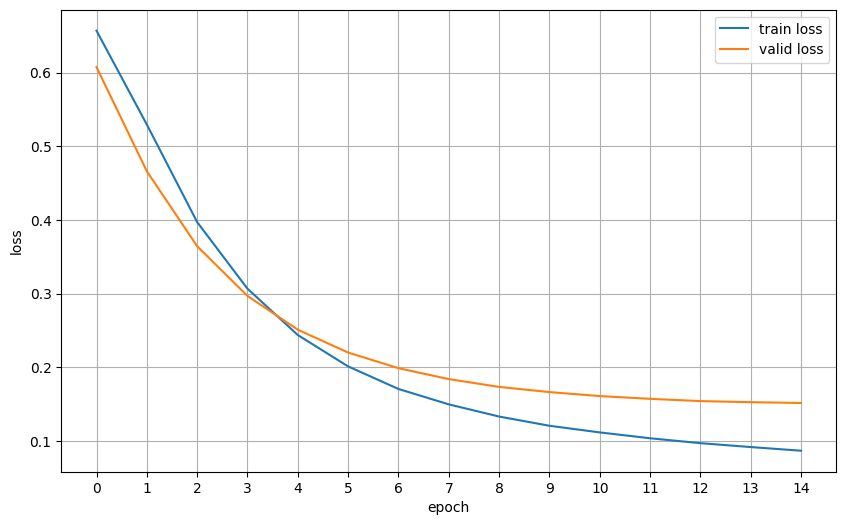

In [120]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

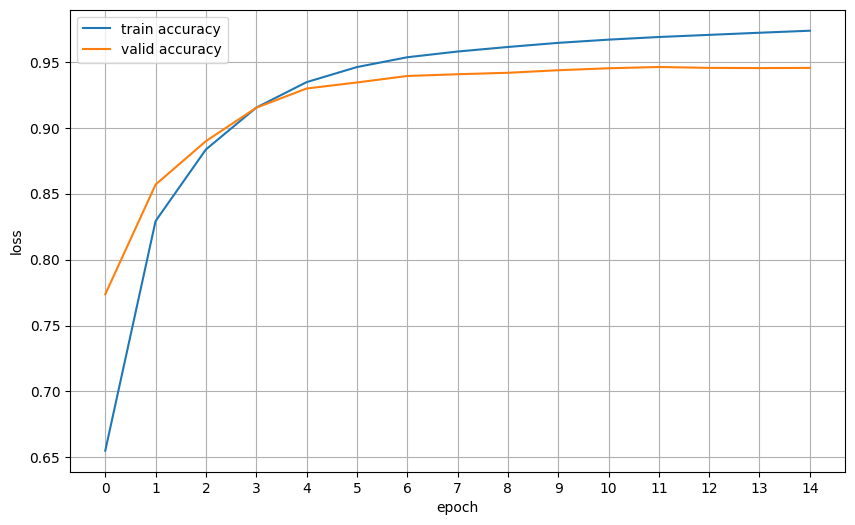

In [121]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [124]:
model.load_state_dict(torch.load("nbow_v1.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.87it/s]


In [125]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.136, test_acc: 0.950


In [127]:
from sklearn.metrics import classification_report

def evaluate_with_report(data_loader, model, criterion):
    model.eval()
    epoch_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"]
            labels = batch["label"]
            preds = model(ids)

            # loss
            loss = criterion(preds, labels)
            epoch_losses.append(loss.item())

            # prédictions finales (argmax si classification multi-classes)
            pred_labels = preds.argmax(dim=1).cpu().numpy()
            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = np.mean(epoch_losses)
    report = classification_report(all_labels, all_preds, digits=4)
    return avg_loss, report


# Exemple d'utilisation
model.load_state_dict(torch.load("nbow_v1.pt"))

test_loss, test_report = evaluate_with_report(test_data_loader, model, criterion)

print("Test Loss:", test_loss)
print("Classification Report:\n", test_report)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.36it/s]

Test Loss: 0.13552690918246904
Classification Report:
               precision    recall  f1-score   support

           0     0.9450    0.9524    0.9487      2921
           1     0.9526    0.9452    0.9489      2955

    accuracy                         0.9488      5876
   macro avg     0.9488    0.9488    0.9488      5876
weighted avg     0.9488    0.9488    0.9488      5876



In [66]:
def predict_sentiment(text, model):
    tokens = nltk.word_tokenize(text)
    ids = lookup_indices(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [78]:
text = "شكراً لكل من سأل عني، أنتم نعمة 💕"

predict_sentiment(text, model)

(1, 0.9993869066238403)

In [79]:
text = "ما في شيء يمشي مثل ما خططت 💭💔"

predict_sentiment(text, model)

(0, 0.9919320940971375)

**Using Embeddings of a model pretrained**

In [80]:
model.embedding.weight

Parameter containing:
tensor([[-0.6534, -0.1361,  0.5599,  ...,  0.2466, -0.5995,  1.1559],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9523,  0.6390,  0.5093,  ...,  0.8721, -0.8748, -1.9885],
        ...,
        [ 0.3950, -0.0852,  0.4837,  ...,  0.9014,  0.8994,  1.8198],
        [ 0.1531, -2.1351, -1.1187,  ..., -0.3122, -0.1037, -0.7491],
        [-0.8534, -0.2391,  0.0702,  ...,  0.7802, -3.2498,  0.6618]],
       requires_grad=True)

In [81]:
from transformers import AutoTokenizer, AutoModel

pretrained_name = "asafaya/bert-base-arabic"
tokenizer = AutoTokenizer.from_pretrained(pretrained_name)
hf_model = AutoModel.from_pretrained(pretrained_name)

hf_embeddings = hf_model.get_input_embeddings().weight.data  # (vocab_hf, 768)
hf_dim = hf_embeddings.shape[1]


target_dim = 128

projection = nn.Linear(hf_dim, target_dim, bias=False)
with torch.no_grad():
    projected_hf_embeddings = projection(hf_embeddings)  # (vocab_hf, 128)

new_weights = torch.zeros(len(stoi), target_dim)

for word, idx in stoi.items():
    sub_tokens = tokenizer.tokenize(word)
    sub_ids = tokenizer.convert_tokens_to_ids(sub_tokens)

    if len(sub_ids) > 0 and all(i != tokenizer.unk_token_id for i in sub_ids):
        vecs = projected_hf_embeddings[sub_ids]
        new_weights[idx] = vecs.mean(dim=0)
    else:
        new_weights[idx] = torch.randn(target_dim)

embedding_layer = nn.Embedding.from_pretrained(new_weights, freeze=False)

print("Embedding matrix shape:", embedding_layer.weight.shape)

C:\Users\user\miniconda3\envs\data\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding matrix shape: torch.Size([89919, 128])


In [82]:
vocab_size = len(stoi)
embedding_dim = 128
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [83]:
embedding_layer.weight

Parameter containing:
tensor([[ 0.8639,  0.6768, -0.5552,  ...,  1.9874, -1.2685, -0.2932],
        [-0.0201, -0.0243,  0.0178,  ..., -0.0100,  0.0115, -0.0158],
        [-0.0138, -0.0104,  0.0243,  ..., -0.0210, -0.0118, -0.0143],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [84]:
model.embedding.weight.data = embedding_layer.weight

In [85]:
model.embedding.weight

Parameter containing:
tensor([[ 0.8639,  0.6768, -0.5552,  ...,  1.9874, -1.2685, -0.2932],
        [-0.0201, -0.0243,  0.0178,  ..., -0.0100,  0.0115, -0.0158],
        [-0.0138, -0.0104,  0.0243,  ..., -0.0210, -0.0118, -0.0143],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [86]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [87]:
n_epochs = 15
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow_emb_pretrained.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.40it/s]


epoch: 0
train_loss: 0.664, train_acc: 0.676
valid_loss: 0.613, valid_acc: 0.851


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.31it/s]


epoch: 1
train_loss: 0.521, train_acc: 0.872
valid_loss: 0.454, valid_acc: 0.879


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.20it/s]


epoch: 2
train_loss: 0.379, train_acc: 0.905
valid_loss: 0.350, valid_acc: 0.907


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.30it/s]


epoch: 3
train_loss: 0.286, train_acc: 0.932
valid_loss: 0.283, valid_acc: 0.922


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.93it/s]


epoch: 4
train_loss: 0.224, train_acc: 0.947
valid_loss: 0.237, valid_acc: 0.933


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.93it/s]


epoch: 5
train_loss: 0.184, train_acc: 0.955
valid_loss: 0.208, valid_acc: 0.940


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.48it/s]


epoch: 6
train_loss: 0.155, train_acc: 0.960
valid_loss: 0.189, valid_acc: 0.942


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.80it/s]


epoch: 7
train_loss: 0.136, train_acc: 0.963
valid_loss: 0.176, valid_acc: 0.944


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.54it/s]


epoch: 8
train_loss: 0.122, train_acc: 0.966
valid_loss: 0.167, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.41it/s]


epoch: 9
train_loss: 0.110, train_acc: 0.968
valid_loss: 0.160, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.28it/s]


epoch: 10
train_loss: 0.102, train_acc: 0.970
valid_loss: 0.156, valid_acc: 0.946


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.90it/s]


epoch: 11
train_loss: 0.095, train_acc: 0.972
valid_loss: 0.153, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.15it/s]


epoch: 12
train_loss: 0.089, train_acc: 0.973
valid_loss: 0.150, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.02it/s]


epoch: 13
train_loss: 0.084, train_acc: 0.975
valid_loss: 0.149, valid_acc: 0.945


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.17it/s]

epoch: 14
train_loss: 0.080, train_acc: 0.976
valid_loss: 0.148, valid_acc: 0.947


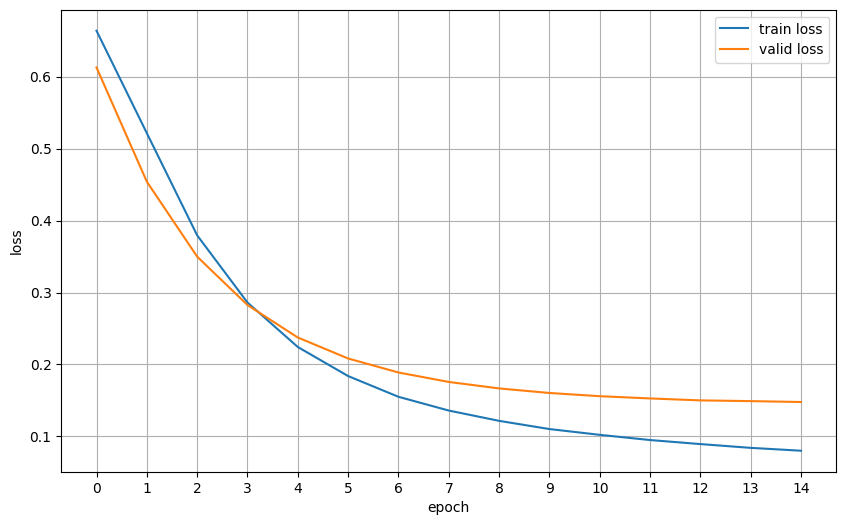

In [88]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

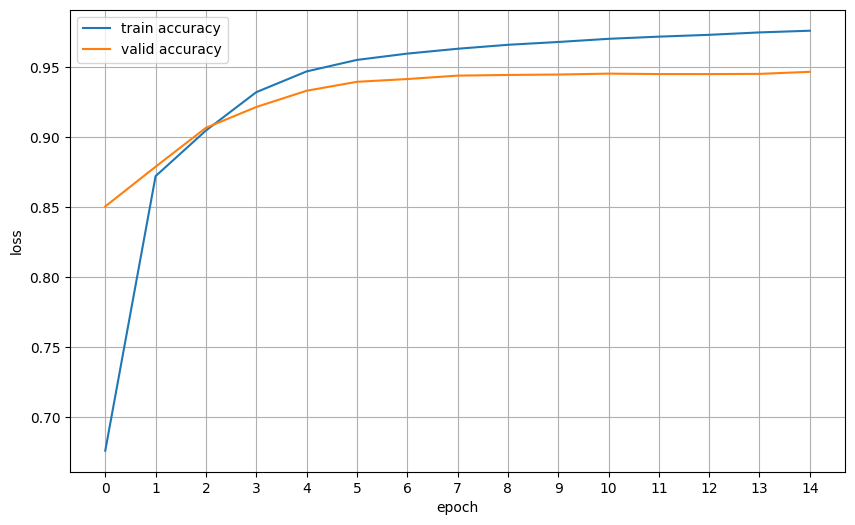

In [89]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [90]:
model.load_state_dict(torch.load("nbow_emb_pretrained.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.06it/s]


In [91]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.134, test_acc: 0.952


In [128]:
model.load_state_dict(torch.load("nbow_emb_pretrained.pt"))

test_loss, test_report = evaluate_with_report(test_data_loader, model, criterion)

print("Test Loss:", test_loss)
print("Classification Report:\n", test_report)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.53it/s]

Test Loss: 0.13376699884732565
Classification Report:
               precision    recall  f1-score   support

           0     0.9467    0.9545    0.9506      2921
           1     0.9546    0.9469    0.9507      2955

    accuracy                         0.9506      5876
   macro avg     0.9507    0.9507    0.9506      5876
weighted avg     0.9507    0.9506    0.9506      5876



evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.74it/s]


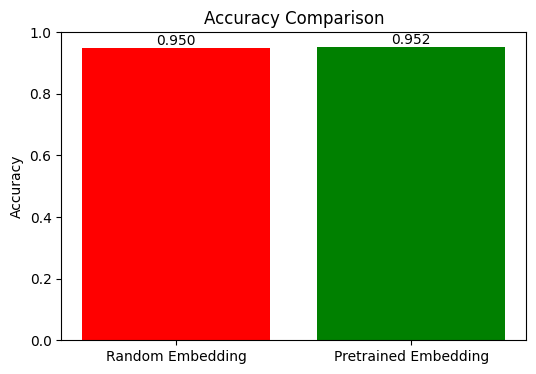

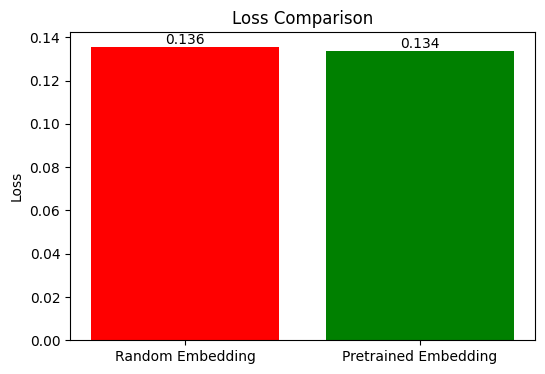

In [129]:
def eval_model(path):
    model.load_state_dict(torch.load(path))
    loss, acc = evaluate(test_data_loader, model, criterion)
    return loss, acc

loss_pretrained, acc_pretrained = eval_model("nbow_emb_pretrained.pt")
loss_random, acc_random = eval_model("nbow_v1.pt")

labels = ["Random Embedding", "Pretrained Embedding"]
losses = [loss_random, loss_pretrained]
accs = [acc_random, acc_pretrained]

# -------------------------------
# Plot Comparaison Accuracy
# -------------------------------
plt.figure(figsize=(6,4))
bars = plt.bar(labels, accs, color=["red", "green"])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.ylim(0, 1)
for bar, val in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{val:.3f}", ha="center", va="bottom")
plt.show()

# -------------------------------
# Plot Comparaison Loss
# -------------------------------
plt.figure(figsize=(6,4))
bars = plt.bar(labels, losses, color=["red", "green"])
plt.ylabel("Loss")
plt.title("Loss Comparison")
for bar, val in zip(bars, losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{val:.3f}", ha="center", va="bottom")
plt.show()